In [1]:
import sys, os, importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

figsize(8, 4)

In [2]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
sys.modules["lumapi"] = lumapi
spec.loader.exec_module(lumapi)
varfdtdApi = lumapi.MODE(hide = False)

C:\Program Files\Lumerical\v221\api\python\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [3]:
# Materials
material_Clad = "SiO2 (Glass) - Dispersive & Lossless"
material_Si = "Si (Silicon) - Dispersive & Lossless"
material_CLAD1 = "SiO2 (Glass) - Palik"
material_SI1 = "Si (Silicon) - Palik"

# Add material
matname = material_Si
matReturn = varfdtdApi.getmaterial(material_Si)
if (varfdtdApi.findstring(matReturn, 'is not available') != -1):
    newmaterial = varfdtdApi.addmaterial("Lorentz")
    varfdtdApi.setmaterial(newmaterial, "name", matname)
    varfdtdApi.setmaterial(matname, "Permittivity", 7.98737492)
    varfdtdApi.setmaterial(matname, "Lorentz Linewidth", 1e8)
    varfdtdApi.setmaterial(matname, "Lorentz Resonance", 3.93282466e+15)
    varfdtdApi.setmaterial(matname, "Lorentz Permittivity", 3.68799143)
    varfdtdApi.setmaterial(matname, "color", np.array([0.85, 0, 0, 1])) # red


In [4]:
matname = material_Clad
matReturn = varfdtdApi.getmaterial(material_Clad)
if (varfdtdApi.findstring(matReturn, 'is not available') != -1):
    newmaterial = varfdtdApi.addmaterial("Lorentz")
    varfdtdApi.setmaterial(newmaterial, "name", matname)
    varfdtdApi.setmaterial(matname, "Permittivity", 2.119881)
    varfdtdApi.setmaterial(matname, "Lorentz Linewidth", 1e10)
    varfdtdApi.setmaterial(matname, "Lorentz Resonance", 3.309283e+13)
    varfdtdApi.setmaterial(matname, "Lorentz Permittivity", 49.43721)
    varfdtdApi.setmaterial(matname, "color", np.array([0.5, 0.5, 0.5, 1])) # grey

In [5]:
um = 1e-6
nm = 1e-9

L_pi_2x2 = 57.32665423030057*um 

# Parâmetros do MMI x
L = round(L_pi_2x2/um)*um

# Parâmetros do MMI y
W = 7*um

# Parâmetros do Taper
W1 = 450*nm
W2 = 1.5*um
LT = 15.0*um

# Parâmetros do guia de onda
wvg_width  = 450*nm
wvg_height = 220*nm

# Comprimento do guia de onda
wvg_length = 4.0*um


In [6]:
# Operação de largura de banda
cband = True
filename = "S_MMI_EME_1x2_%d_um" %(L/um)

# Simulação da Banda C: 1520 - 1575 nm
# Simulação da Banda L: 1555 - 1635 nm
if cband:
    wvlngth_start = 1.520*um
    wvlngth_stop  = 1.575*um
else:
    wvlngth_start = 1.555*um
    wvlngth_stop  = 1.635*um
nmbFrqPnts = 20


In [7]:
# Adicionando grupo de estrutura
varfdtdApi.deleteall()

varfdtdApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
varfdtdApi.set('name', dev_layer)

# Adicionando retângulo
varfdtdApi.addrect()
varfdtdApi.addtogroup(dev_layer)
varfdtdApi.set('name', 'box')
varfdtdApi.set('x', 0)
varfdtdApi.set('x span', L)
varfdtdApi.set('y', 0)
varfdtdApi.set('y span', W)
varfdtdApi.set('z', wvg_height/2)
varfdtdApi.set('z span', wvg_height)
varfdtdApi.set('material', material_SI1)

# Adicionando tapers lineares
for i in range(4):
    varfdtdApi.addobject('linear_taper')
    varfdtdApi.set('name', 'taper port ' + str(i + 1))
    varfdtdApi.set('thickness', wvg_height)
    varfdtdApi.set('angle_side', 90)
    varfdtdApi.set('width_l', W2)
    varfdtdApi.set('width_r', W1)
    varfdtdApi.set('len', LT)
    varfdtdApi.set('material', material_SI1)
    varfdtdApi.set('x', varfdtdApi.getnamed(f'{dev_layer}::box', 'x max') + LT/2)
    varfdtdApi.set('y', W/6)
    varfdtdApi.set('z', wvg_height/2)

## 01
varfdtdApi.select(f"{dev_layer}::taper port 1")
varfdtdApi.set("width_l", W1)
varfdtdApi.set("width_r", W2)
varfdtdApi.set("x", varfdtdApi.getnamed(f"{dev_layer}::box", "x max") - LT/2 - L)
varfdtdApi.set("y", W/6)

## 04
varfdtdApi.select(f"{dev_layer}::taper port 4")
varfdtdApi.set("width_l", W1)
varfdtdApi.set("width_r", W2)
varfdtdApi.set("x", varfdtdApi.getnamed(f"{dev_layer}::box", "x max") - LT/2 - L)
varfdtdApi.set("y", -W/6)

## 03
varfdtdApi.select(f"{dev_layer}::taper port 3")
varfdtdApi.set("y", -W/6)



In [8]:
## Waveguides
for i in range(4):
    varfdtdApi.select(f"{dev_layer}::port {str(i + 1)}")
    varfdtdApi.delete()

for i in range(4):
    varfdtdApi.addrect()
    varfdtdApi.addtogroup(dev_layer)
    varfdtdApi.set('name', f"port {str(i + 1)}")
    varfdtdApi.set('x', (L + wvg_length + 2 * LT) / 2)
    varfdtdApi.set('x span', wvg_length)
    varfdtdApi.set('y', W / 6)
    varfdtdApi.set('y span', wvg_width)
    varfdtdApi.set('z', wvg_height / 2)
    varfdtdApi.set('z span', wvg_height)
    varfdtdApi.set('material', material_SI1)

## 01
varfdtdApi.select(f"{dev_layer}::port 1")
varfdtdApi.set('x', -(L + wvg_length + 2 * LT) / 2)
varfdtdApi.set('y', -W/6)

## 04
varfdtdApi.select(f"{dev_layer}::port 4")
varfdtdApi.set('x', -(L + wvg_length + 2 * LT) / 2)
varfdtdApi.set('y', W/6)

## 03
varfdtdApi.select(f"{dev_layer}::port 3")
varfdtdApi.set('y', -W / 6)


In [9]:
varfdtdApi.select("varFDTD")
varfdtdApi.delete()

ponto1 = L/2.4
ponto2 = 8*um

number_of_points = 50

pontos = np.array([
    [1.14*ponto1, 0.3*ponto2],
    [1.14*ponto1, -0.3*ponto2],
    [-ponto1, ponto2],
    [-ponto1, -ponto2]
])


bound_x_offset = 2*um
bound_y_offset = 2*um
bound_z_offset = 3.5*um

varfdtdApi.addvarfdtd()
varfdtdApi.set("simulation time", 2000e-15)
varfdtdApi.set("x", 0)
varfdtdApi.set("y", 0)
varfdtdApi.set("z", wvg_height/2)
varfdtdApi.set("x span", L + 17*bound_x_offset)
varfdtdApi.set("y span", W + 8*bound_y_offset)
varfdtdApi.set("z span", bound_z_offset)
varfdtdApi.set("x0", -ponto1)
varfdtdApi.set("bandwidth", 2)
varfdtdApi.set("test points", pontos)
varfdtdApi.set("background material", "SiO2 (Glass) - Palik")
varfdtdApi.set("global monitor frequency points", number_of_points)
varfdtdApi.set("mesh accuracy", 3)

## Boundary Conditions
varfdtdApi.set("y min bc", "PML")
varfdtdApi.set("y max bc", "PML")
varfdtdApi.set("z min bc", "Symmetric")
varfdtdApi.set("z max bc", "PML")



In [10]:
varfdtdApi.select("source")
varfdtdApi.delete()

varfdtdApi.addmodesource();
varfdtdApi.set("injection axis", "x");
varfdtdApi.set("x", -L/2-LT-wvg_length/2.3);
varfdtdApi.set("y", W/6);
varfdtdApi.set("y span", 3*um);
varfdtdApi.set("wavelength start", 1500e-9);
varfdtdApi.set("wavelength stop", 1600e-9);

In [11]:
varfdtdApi.select("monitor")
varfdtdApi.delete()

varfdtdApi.addprofile()
varfdtdApi.set("x", 0)
varfdtdApi.set("y", 0)
varfdtdApi.set("x span", L + 17*bound_x_offset)
varfdtdApi.set("y span", W + 8*bound_y_offset)


In [12]:
for i in range(4):
    varfdtdApi.select(f"port{i+1}")
    varfdtdApi.delete()


varfdtdApi.addpower()
varfdtdApi.set("name", "port1")
varfdtdApi.set("monitor type", 5)
varfdtdApi.set("x", -L/2-LT-wvg_length/2.3);
varfdtdApi.set("y", W/6);
varfdtdApi.set("y span", 2*um);
varfdtdApi.set("z span", bound_z_offset)

varfdtdApi.addpower()
varfdtdApi.set("name", "port2")
varfdtdApi.set("monitor type", 5)
varfdtdApi.set("x", -L/2-LT-wvg_length/2.3);
varfdtdApi.set("y", -W/6);
varfdtdApi.set("y span", 2*um);
varfdtdApi.set("z span", bound_z_offset)

varfdtdApi.addpower()
varfdtdApi.set("name", "port3")
varfdtdApi.set("monitor type", 5)
varfdtdApi.set("x", L/2+LT+wvg_length/2.3);
varfdtdApi.set("y", W/6);
varfdtdApi.set("y span", 2*um);
varfdtdApi.set("z span", bound_z_offset)

varfdtdApi.addpower()
varfdtdApi.set("name", "port4")
varfdtdApi.set("monitor type", 5)
varfdtdApi.set("x", L/2+LT+wvg_length/2.3);
varfdtdApi.set("y", -W/6);
varfdtdApi.set("y span", 2*um);
varfdtdApi.set("z span", bound_z_offset)


In [13]:
varfdtdApi.save("MMI VARFDTD")
varfdtdApi.run()

## Perfil de Campo

In [14]:
# Field profile
E = varfdtdApi.getresult("monitor", "E")

x = E['x']
x = x[:,0]/um

y = E['y']
y = y[:,0]/um
z = E['z']
E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

Text(-42, -3, 'Porta 3')

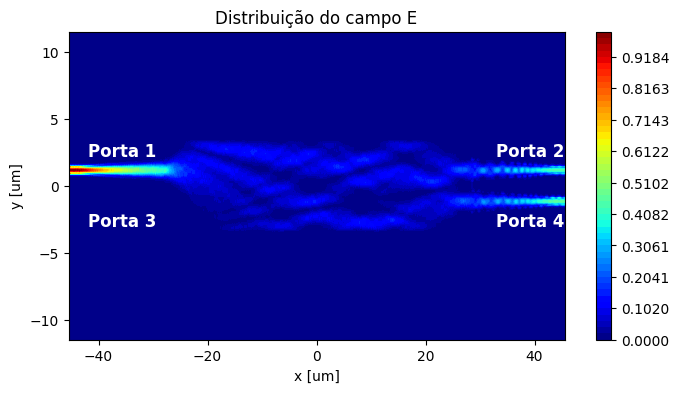

In [19]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 50, endpoint=True)

plt.contourf(x, y, np.transpose(Emag[:,:,0]**2), v, cmap=mycmap)
plt.colorbar()

plt.title('Distribuição do campo E', fontsize=12)
plt.ylabel('y [um]', fontsize=10)
plt.xlabel('x [um]', fontsize=10)

plt.text(-42, 2.2, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(33, -3, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(33, 2.2, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(-42, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')

Text(-42, -3, 'Porta 3')

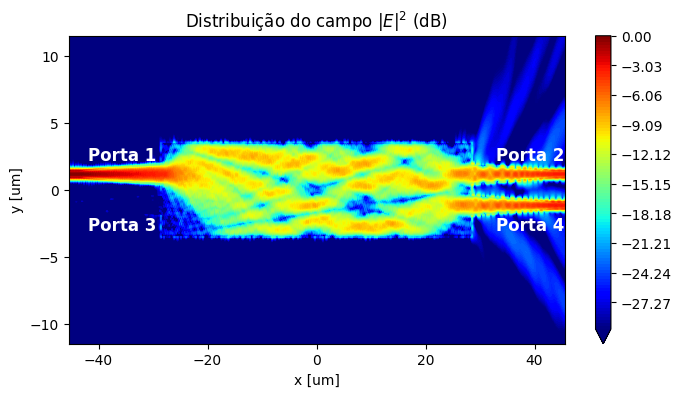

In [26]:
plt.figure()
v = np.linspace(-30, 0, 100, endpoint=True)

plt.title(r'Distribuição do campo $|E|^2$ (dB)', fontsize=12)
plt.ylabel(r'y [um]', fontsize=10)
plt.xlabel(r'x [um]', fontsize=10)

CS = plt.contourf(x, y, 10*np.log10(np.transpose(Emag[:, :,0]**2)), v, cmap=mycmap, extend='min')
plt.colorbar()

plt.text(-42, 2.2, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(33, -3, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(33, 2.2, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(-42, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')


## Transmissão

In [22]:
T1 = np.abs(varfdtdApi.getresult("port1", "T")['T'])
T2 = np.abs(varfdtdApi.getresult("port3", "T")['T'])
T3 = np.abs(varfdtdApi.getresult("port2", "T")['T'])
T4 = np.abs(varfdtdApi.getresult("port4", "T")['T'])

T1_dB = 10*np.log10(T1)
T2_dB = 10*np.log10(T2)
T3_dB = 10*np.log10(T3)
T4_dB = 10*np.log10(T4)

Lambda = varfdtdApi.getresult("port1", "T")['lambda']

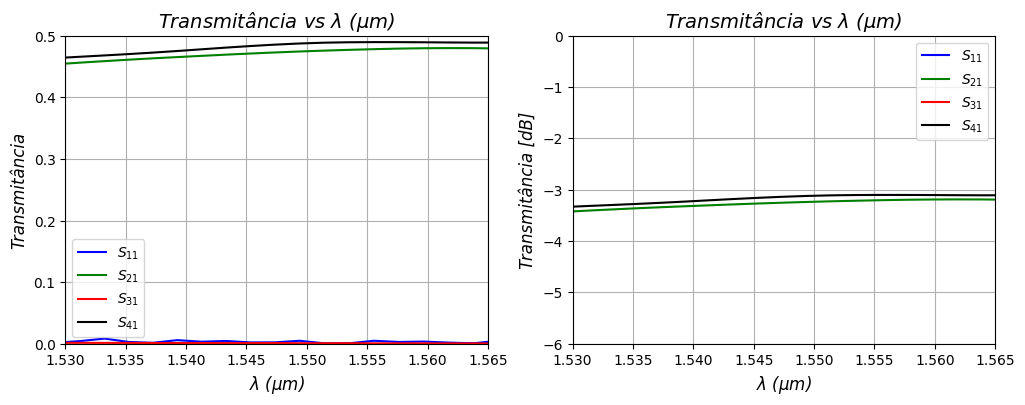

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(Lambda/um, T1, 'b', lw=1.5, label='$S_{11}$')
axs[0].plot(Lambda/um, T2, 'g', lw=1.5, label='$S_{21}$')
axs[0].plot(Lambda/um, T3, 'r', lw=1.5, label='$S_{31}$')
axs[0].plot(Lambda/um, T4, 'k', lw=1.5, label='$S_{41}$')
axs[0].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize=12, fontstyle='italic')
axs[0].set_ylabel('Transmitância', fontsize=12, fontstyle='italic')
axs[0].set_title(r'Transmitância vs $\lambda$ ($\mu$m)', fontsize=14, fontstyle='italic')
axs[0].set_xlim([1.53, 1.565])
axs[0].set_ylim([0, 0.5])
axs[0].grid()
axs[0].legend()

axs[1].plot(Lambda/um, T1_dB, 'b', lw=1.5, label='$S_{11}$')
axs[1].plot(Lambda/um, T2_dB, 'g', lw=1.5, label='$S_{21}$')
axs[1].plot(Lambda/um, T3_dB, 'r', lw=1.5, label='$S_{31}$')
axs[1].plot(Lambda/um, T4_dB, 'k', lw=1.5, label='$S_{41}$')
axs[1].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize=12, fontstyle='italic')
axs[1].set_ylabel('Transmitância [dB]', fontsize=12, fontstyle='italic')
axs[1].set_title(r'Transmitância vs $\lambda$ ($\mu$m)', fontsize=14, fontstyle='italic')
axs[1].set_xlim([1.53, 1.565])
axs[1].set_ylim([-6, 0])
axs[1].grid()
axs[1].legend()


## Perda de inserção

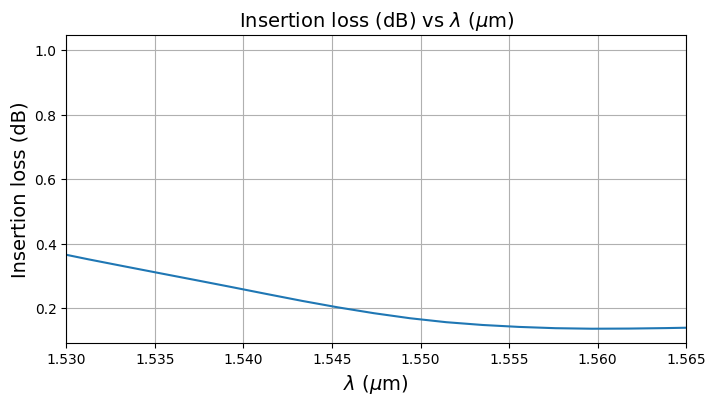

In [25]:
### Insertion Loss
IL = -10 * np.log10(T4 + T2)
plt.plot(Lambda/um, IL, lw=1.5)
plt.xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
plt.ylabel(r'Insertion loss (dB)', fontsize=14)
plt.title(r'Insertion loss (dB) vs $\lambda$ ($\mu$m)', fontsize=14)
plt.xlim([1.53, 1.565])
plt.grid()

## Repetição das simulações para modo TM

In [27]:
varfdtdApi.switchtolayout()

varfdtdApi.select("varFDTD")
varfdtdApi.set("z min bc", "Anti-Symmetric")


In [28]:
varfdtdApi.save("MMI VARFDTD")
varfdtdApi.run()

In [29]:
# Field profile
E = varfdtdApi.getresult("monitor", "E")

x = E['x']
x = x[:,0]/um

y = E['y']
y = y[:,0]/um
z = E['z']
E = E['E']

Ex = E[:,:,0,:,0]
Ey = E[:,:,0,:,1]
Ez = E[:,:,0,:,2]

Emag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2)

Text(-42, -3, 'Porta 3')

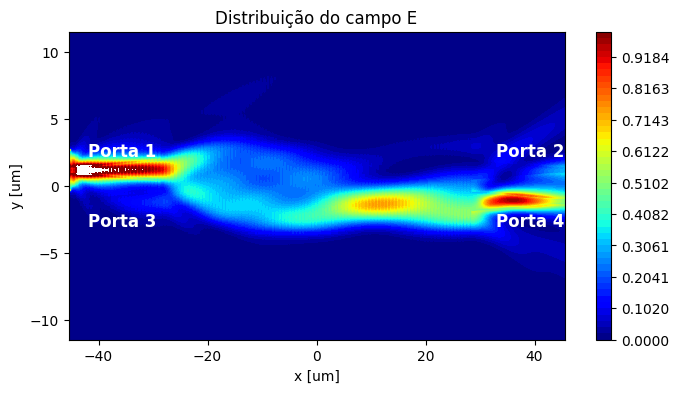

In [30]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 50, endpoint=True)

plt.contourf(x, y, np.transpose(Emag[:,:,0]**2), v, cmap=mycmap)
plt.colorbar()

plt.title('Distribuição do campo E', fontsize=12)
plt.ylabel('y [um]', fontsize=10)
plt.xlabel('x [um]', fontsize=10)

plt.text(-42, 2.2, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(33, -3, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(33, 2.2, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(-42, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')



Text(-42, -3, 'Porta 3')

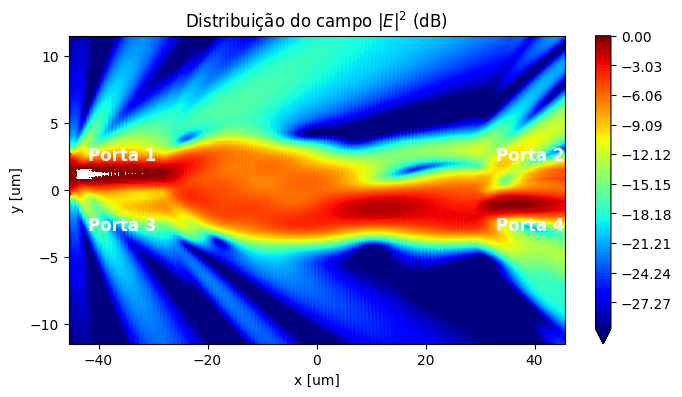

In [35]:
plt.figure()
v = np.linspace(-30, 0, 100, endpoint=True)

plt.title(r'Distribuição do campo $|E|^2$ (dB)', fontsize=12)
plt.ylabel(r'y [um]', fontsize=10)
plt.xlabel(r'x [um]', fontsize=10)

CS = plt.contourf(x, y, 10*np.log10(np.transpose(Emag[:, :,0]**2)), v, cmap=mycmap, extend='min')
plt.colorbar()

plt.text(-42, 2.2, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(33, -3, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(33, 2.2, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(-42, -3, 'Porta 3', fontsize=12, fontweight='bold', color='w')

In [38]:
T1 = np.abs(varfdtdApi.getresult("port1", "T")['T'])
T3 = np.abs(varfdtdApi.getresult("port2", "T")['T'])
T2 = np.abs(varfdtdApi.getresult("port3", "T")['T'])
T4 = np.abs(varfdtdApi.getresult("port4", "T")['T'])

T1_dB = 10*np.log10(T1)
T2_dB = 10*np.log10(T2)
T3_dB = 10*np.log10(T3)
T4_dB = 10*np.log10(T4)

Lambda = varfdtdApi.getresult("port1", "T")['lambda']

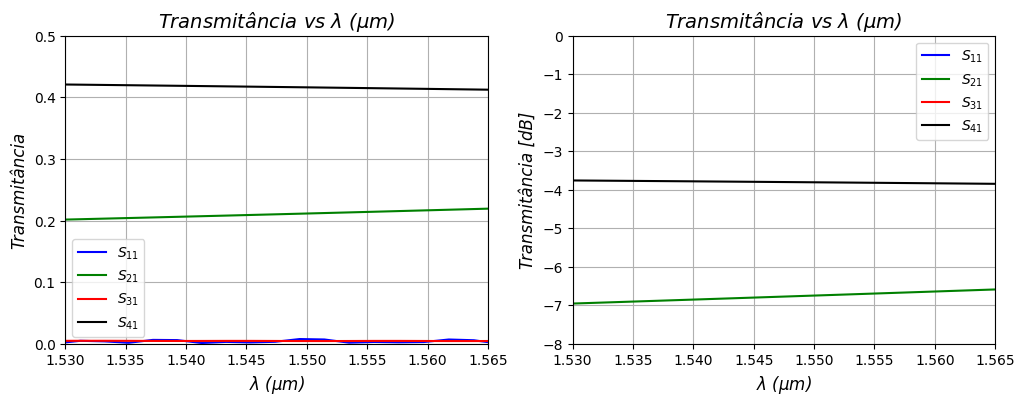

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(Lambda/um, T1, 'b', lw=1.5, label='$S_{11}$')
axs[0].plot(Lambda/um, T2, 'g', lw=1.5, label='$S_{21}$')
axs[0].plot(Lambda/um, T3, 'r', lw=1.5, label='$S_{31}$')
axs[0].plot(Lambda/um, T4, 'k', lw=1.5, label='$S_{41}$')
axs[0].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize=12, fontstyle='italic')
axs[0].set_ylabel('Transmitância', fontsize=12, fontstyle='italic')
axs[0].set_title(r'Transmitância vs $\lambda$ ($\mu$m)', fontsize=14, fontstyle='italic')
axs[0].set_xlim([1.53, 1.565])
axs[0].set_ylim([0, 0.5])
axs[0].grid()
axs[0].legend()

axs[1].plot(Lambda/um, T1_dB, 'b', lw=1.5, label='$S_{11}$')
axs[1].plot(Lambda/um, T2_dB, 'g', lw=1.5, label='$S_{21}$')
axs[1].plot(Lambda/um, T3_dB, 'r', lw=1.5, label='$S_{31}$')
axs[1].plot(Lambda/um, T4_dB, 'k', lw=1.5, label='$S_{41}$')
axs[1].set_xlabel(r'$\lambda$ ($\mu$m)', fontsize=12, fontstyle='italic')
axs[1].set_ylabel('Transmitância [dB]', fontsize=12, fontstyle='italic')
axs[1].set_title(r'Transmitância vs $\lambda$ ($\mu$m)', fontsize=14, fontstyle='italic')
axs[1].set_xlim([1.53, 1.565])
axs[1].set_ylim([-8, 0])
axs[1].grid()
axs[1].legend()


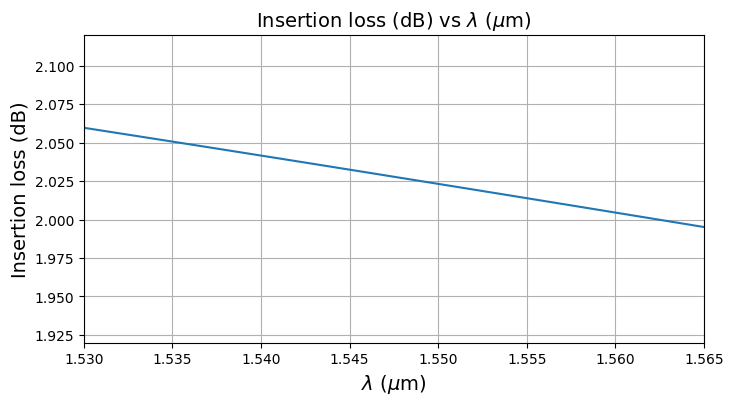

In [34]:
### Insertion Loss
IL = -10 * np.log10(T4 + T3)
plt.plot(Lambda/um, IL, lw=1.5)
plt.xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
plt.ylabel(r'Insertion loss (dB)', fontsize=14)
plt.title(r'Insertion loss (dB) vs $\lambda$ ($\mu$m)', fontsize=14)
plt.xlim([1.53, 1.565])
plt.grid()